
# Linear Regression Example
The example below uses a [marketing](https://scikit-learn.org/stable/datasets/toy_dataset.html) dataset,
in order to illustrate a linear regression activity.

Workflow:



1. Preparation
    1. Load the dataset from a `.csv` file and show a short description
    1. Show the two dimensional scatter plots for all the predicting variables with respect to the target
    1. Split the data into *predicting variables* `X` and *target* `y`
        1. here we set the `random_state` variable to make the experiment *repeatable* 
1. First experiment: compute the regression on a single predicting variable
    1. Consider a reduced dataset containing the chosen variable and the target
    1. Fit the `LinearRegression` estimator on the training set
    1. Show the statistical significance of the fitted model
    1. Predict the target for the test set using the *fitted* estimator
    1. Compute the regression coefficients and the quality measures: *Root Mean Squared Error (RMSE)* and *coefficient of determination (r2)*
1. Second experiment: compute the regression considering all the predicting variables
    1. Repeat the steps from 2.2 to 2.5
1. Third experiment: use the `DecisionTreeRegressor` with the entire dataset
    1. Fit the tree using the default hyperparameters, in order to find the 
    maximum depth of the unconstrained tree
    1. Use *cross-validation* to find the optimal *maximum depth* of the tree
    1. Fit the tree with the optmal `max_depth`
    1. Predict and show the *root mean squared error*
1. Fourth experiment: use the `RandomForestRegressor`
    1. Repeat steps from 4.2 to 4.4 (for simplicity, we use the maximum `max_depth` found in 4.1)


In [161]:
# Code source: Claudio Sartori 
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split

random_state = 94922767 # this will be used to guarantee the repeatability of the experiment

## Load the dataset from a `.xlsx` file and show a short description

In [162]:
# This cell allows full compatibility between execution in Google Colab and in local
try:
  import google.colab.files
  IN_COLAB = True
except:
  IN_COLAB = False
# from google.colab import files
if IN_COLAB:
    uploaded = files.upload()

In [163]:
# The file must be available in the same directory, 
# or uploaded in the Colab environment 
# in the execution of the previous cell
data_fn = 'FoodUK2014.xlsx'
df0 = pd.read_excel(data_fn)

## Data Exploration and preparation

##### Show a short description of the columns

In [164]:
df0.describe()
df0.head()

,hhsize,quarter,adults_n,children_n,totalexp,SexHRP,month,Gorx,Year,income,AgeHRP,qmeat,qfish,qfv,xmeat,xfish,xfv,uvmeat,uvfish,uvfv
0,4,April to June,2,2,556.213795,Female,April,West Midlands,2014,985.655,34,13.745333,NaN,37.301331,96.156670,NaN,69.268333,6.995586,NaN,1.856993
1,4,July to September,2,2,737.685635,Male,August,North East,2014,824.520,38,6.045000,0.650000,30.203335,53.278336,6.500000,62.833336,8.813621,10.000000,2.080344
2,2,October to December,2,0,330.775000,Male,October,Northern Ireland,2014,271.925,54,11.780167,2.088667,17.032166,93.838333,28.491667,42.813335,7.965790,13.641079,2.513675
3,2,April to June,2,0,536.742283,Male,June,North West and Merseyside,2014,611.490,64,2.745167,NaN,4.008333,16.856667,NaN,5.416667,6.140490,NaN,1.351351
4,3,April to June,3,0,880.787157,Male,April,East Midlands,2014,496.040,64,12.857000,2.903333,7.345000,73.623337,16.921667,19.261665,5.726323,5.828358,2.622419


##### Show the number of rows with nulls

It is computed subtracting the number of rows in the dataset without nulls from the original number of rows

In [165]:
nonnull=df0.dropna()
print(df0.shape[0]-nonnull.shape[0])

1668


#### Drop rows with nulls

In [166]:
df0=df0.dropna()
df0.shape

(3446, 20)

##### Data transormation
- Convert the alphanumeric SexHRP into numeric 0 and 1
    - the `sklearn` machine learning procedures work only with numeric predicting
      attributes
- Generate two new columns as ratio of other columns
    - this is suggested by background information

In [167]:
df0.SexHRP.replace(("Male","Female"),(1,0),inplace=True)

df0.columns
df0["qmeat_hhsize_ratio"]=df0.qmeat/df0.hhsize
df0["income_hhsize_ratio"]=df0.income/df0.hhsize
df0.head()

,hhsize,quarter,adults_n,children_n,totalexp,SexHRP,month,Gorx,Year,income,...,qfish,qfv,xmeat,xfish,xfv,uvmeat,uvfish,uvfv,qmeat_hhsize_ratio,income_hhsize_ratio
1,4,July to September,2,2,737.685635,1,August,North East,2014,824.520,...,0.650000,30.203335,53.278336,6.500000,62.833336,8.813621,10.000000,2.080344,1.511250,206.130000
2,2,October to December,2,0,330.775000,1,October,Northern Ireland,2014,271.925,...,2.088667,17.032166,93.838333,28.491667,42.813335,7.965790,13.641079,2.513675,5.890083,135.962500
4,3,April to June,3,0,880.787157,1,April,East Midlands,2014,496.040,...,2.903333,7.345000,73.623337,16.921667,19.261665,5.726323,5.828358,2.622419,4.285667,165.346667
5,4,January to March,2,2,372.275578,1,February,Wales,2014,266.530,...,1.789667,27.378000,303.181671,28.773333,86.558327,8.451528,16.077482,3.161602,8.968250,66.632500
7,3,January to March,3,0,151.750522,1,January,Eastern,2014,403.180,...,3.003000,6.742667,72.258331,26.000000,17.376667,5.904745,8.658009,2.577121,4.079111,134.393333


##### Use only the columns that the experts consider interesting
This is suggested by background information

In [168]:
colonneselezionate=["adults_n","children_n","SexHRP","AgeHRP","qmeat_hhsize_ratio","income_hhsize_ratio","uvmeat"]
colonnedaeliminare=[i for i in list(df0.columns) if i not in colonneselezionate]
for i in colonnedaeliminare:
    df0=df0.drop(i,axis=1)
df=df0

## Choose the target and split the data into *predicting variables* `X` and *target* `y`

In [169]:
target="qmeat_hhsize_ratio"
y=df[target]
X=df[[i for i in colonneselezionate if i!=target]]


## Show the two dimensional scatter plots for all the predicting variables with respect to the target

In [170]:
ncols=3
import math
nrows = math.ceil((df.shape[1]-1)/ncols)
figwidth = ncols * 7
figheigth = nrows*5

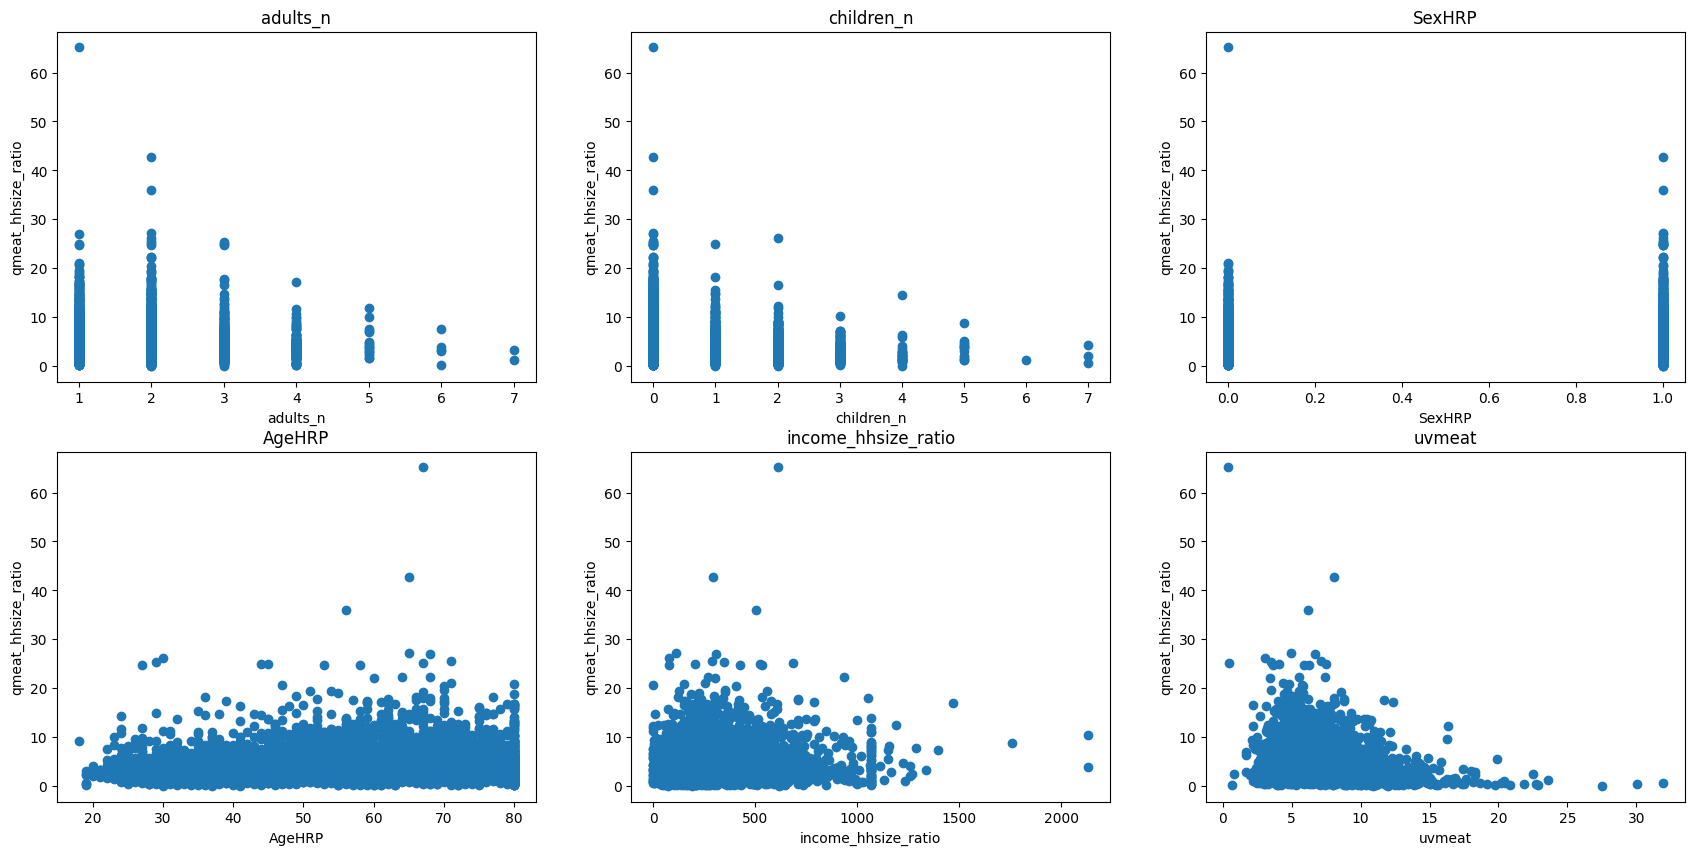

In [171]:
plt.figure(figsize=(figwidth,figheigth))
for i,e in enumerate(X.columns):
        plt.subplot(nrows,ncols,i+1)
        plt.scatter(X[e],y)
        plt.title(e)
        plt.xlabel(e)
        plt.ylabel(target)
plt.show()


### Show the *_p-values_* of the target with respect to the variables

In [172]:
from sklearn.feature_selection import f_regression
# Your code here
features, p_value=f_regression(X,y)

## Split the data into *train* and *test* and show the sizes of the two parts
Here we set the `random_state` variable to make the experiment *repeatable*


In [173]:
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,train_size= 2412 ,random_state=random_state)

### Consider a reduced dataset containing the chosen variable and the target

In [201]:
Xt=Xtrain[["income_hhsize_ratio"]]
Xtest_=Xtest[["income_hhsize_ratio"]]

### Fit the `linear_model` estimator on the training set and predict the target for the test set using the *fitted* estimator

In [203]:
l=linear_model.LinearRegression()
l.fit(Xt, ytrain)
ypred=l.predict(Xtest_)
print(ypred)

[4.88023728 5.15586474 4.89388044 ... 5.10527966 5.15586474 5.24980111]


#### Compute the regression coefficients and the quality measures
Create a function to compute the F-statistic and p-value of the regression model

In [ ]:
# Computation of F-statistic and p-value for the regression
# http://facweb.cs.depaul.edu/sjost/csc423/documents/f-test-reg.htm


#### Compute the statistical significance of the model

## Second experiment: compute the regression considering all the predicting variables

### Now we use the entire data in `X_train` and `X_test` for fitting and predicting

In [199]:
l=linear_model.LinearRegression()
l.fit(Xtrain, ytrain)
ypred=l.predict(Xtrain)
print(ypred)

[6.60486666 5.74918915 5.72672858 ... 6.41887666 5.33151699 6.12822425]


### Fit, predict and show the results
Now we see the *regression coefficients* resulting from the fitting. 

In particular, *positive coefficients* indicate that the target *increases* with the variable, *negative coefficients* indicate a *decreasing* trend.

The absolute values of the coefficient cannot be considered directly a measure of importance, due to the possibly different orders of magnitude of the data in the different columns (observe above the outputs of `describe`).

#### Compute the statistical significance

#### Compute the quality measures

## Decision Tree Multivariate Regresson

In [ ]:
# Create Decision Tree regression object
from sklearn.tree import DecisionTreeRegressor

#### Fit the tree with default hyperparameters, and find the maximum depth of the unconstrained tree

#### Find the optimal value of the hyperparameter `max_depth` with *cross-validation*
The optimization searches for the *maximum tree depth* guaranteing the smallest mean squared error
At the end, this operation returns also the *fitted best tree* `best_estimator_`

#### Show the tree

In [ ]:
from sklearn.tree import plot_tree
from matplotlib.pyplot import figure
# Your code here

## Random Forest Multivariate Regresson
Create a Random forest regressor and fit it on the complete dataset.

For simplicity use the max_depth found in the Decision tree regressor to perform a cross validation and find the best depth for this model.

## Final observations
### Linear regression
The multivariate regression with all the predicting variables available with respect to the univariate regression has 
- lower RMSE 
- higher coefficient of determination 
- the p-value suggests the acceptance of both models
### Decision Tree and Random Forest regression
- Decistion Tree has an RMSE slightly higher than multivariate linear regression
- Random Forest has an RMSE slightly lower than multivariate linear regression


## Control questions
1. observing the multi-variate experiment, what variable has the higher effect on the target?
1. is there a variable having an almost negligible effect on the target?
1. try to repeat the univariate experiment with the other two columns and comment the results